In [2]:
import solvers
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
grid_resolution = 768, 768
window_res = 768, 768

current_frame = torch.zeros((*grid_resolution, 3), dtype=torch.float32)

next_frame = solvers.interaction_step(
	frame=current_frame,
	interaction_radius=120,
	mouse_x=384,
	mouse_y=384,
	grid_resolution=grid_resolution,
	window_res=window_res,
	mouse_acceleration=(50, 50),
	dt=1,
)

def normalize_array(arr):
    """Scales an input NumPy array to the range [0, 1]."""
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(arr)#love yyou beo


next_frame = normalize_array(next_frame.numpy())

next_frame = (next_frame * 255).astype(np.uint8)

plt.figure(figsize=(16, 16))
plt.imshow(next_frame[:, :, 0])
plt.show()

TypeError: interaction_step() missing 2 required positional arguments: 'interaction_strength' and 'reset_request'

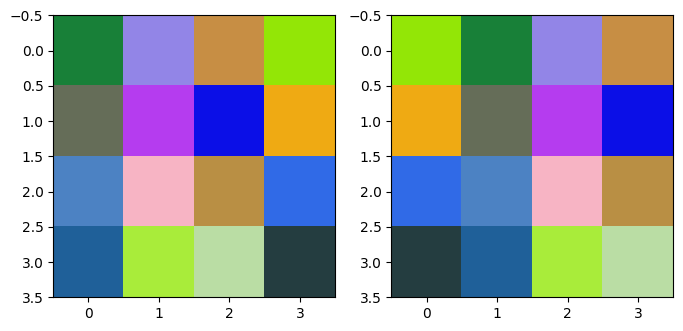

In [4]:
grid = torch.rand((4, 4, 3))

up = torch.roll(grid, -1, dims=0)
down = torch.roll(grid, 1, dims=0)

left = torch.roll(grid, -1, dims=1)
right = torch.roll(grid, 1, dims=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(grid)

axs[1].imshow(right)

plt.show()

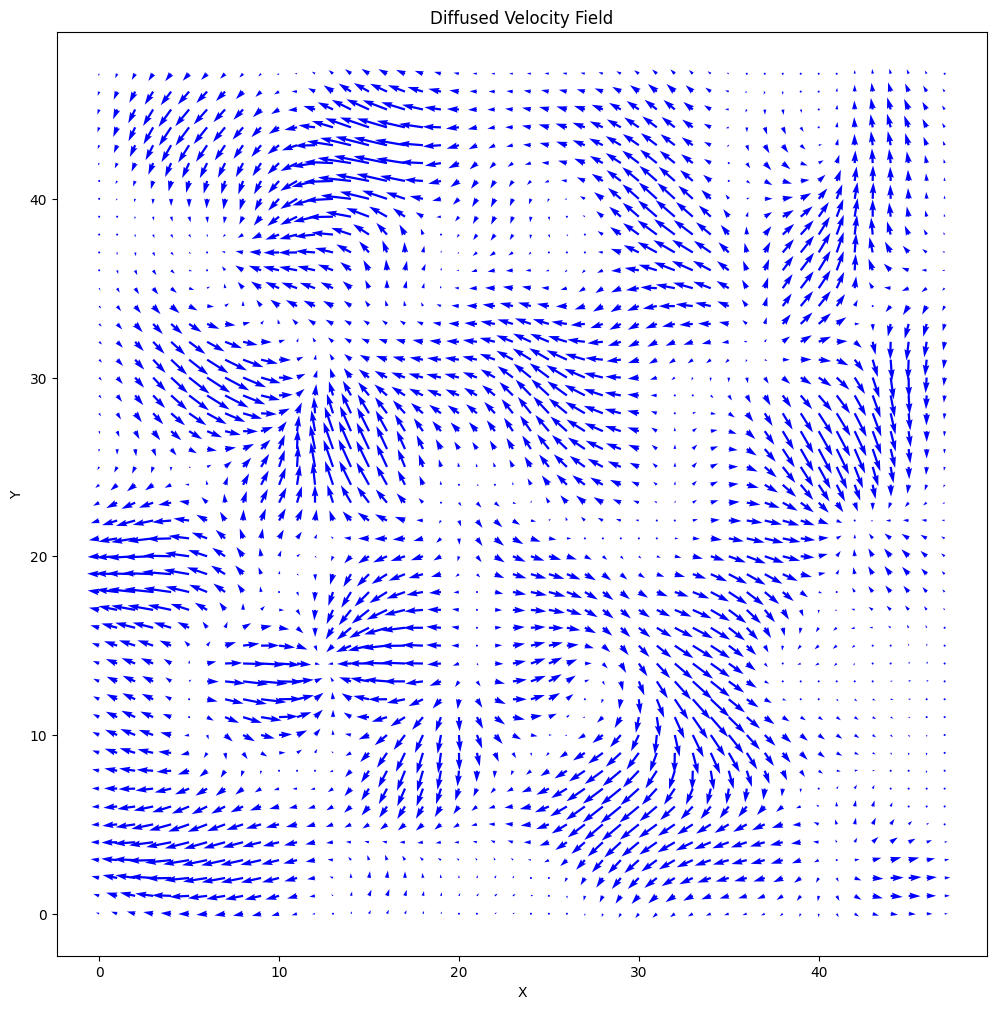

In [5]:
import torch.nn.functional as F

W, H = 48, 48
diffusion_strength = 0.1

velocity = torch.randn(W, H, 2)

def diffuse_velocity(vel, strength=0.1, iterations=10):
    for _ in range(iterations):
        vel = F.avg_pool2d(vel.permute(2, 0, 1).unsqueeze(0), kernel_size=3, stride=1, padding=1).squeeze(0).permute(1, 2, 0)
        vel = (1 - strength) * vel + strength * vel
    return vel


def plot_velocity(vel):
	vx, vy = vel[..., 0].numpy(), vel[..., 1].numpy()

	# Create a quiver plot
	x = np.linspace(0, W-1, W)
	y = np.linspace(0, H-1, H)
	X, Y = np.meshgrid(x, y)

	plt.figure(figsize=(12, 12))
	plt.quiver(X, Y, vx, vy, scale=10, color='blue')
	plt.title("Diffused Velocity Field")
	plt.xlabel("X")
	plt.ylabel("Y")
	plt.show()

velocity = diffuse_velocity(velocity, diffusion_strength)

plot_velocity(velocity)

tensor(-0.1619) tensor(0.1239)


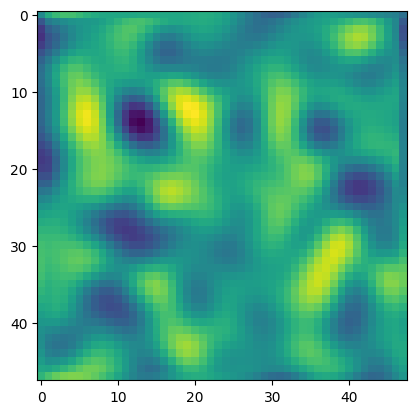

In [6]:
up = torch.roll(velocity, -1, dims=0)
down = torch.roll(velocity, 1, dims=0)

left = torch.roll(velocity, -1, dims=1)
right = torch.roll(velocity, 1, dims=1)

divergence = ((up[:, :, 1] - down[:, :, 1]) - (right[:, :, 0] - left[:, :, 0])) / 2
print(torch.min(divergence), torch.max(divergence))

plt.imshow(divergence)
plt.show()

In [7]:
org_velocity = velocity.clone()

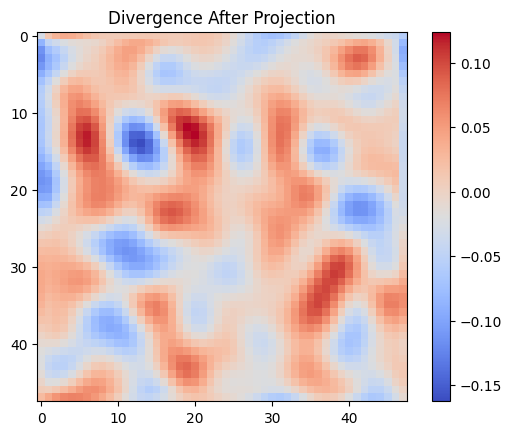

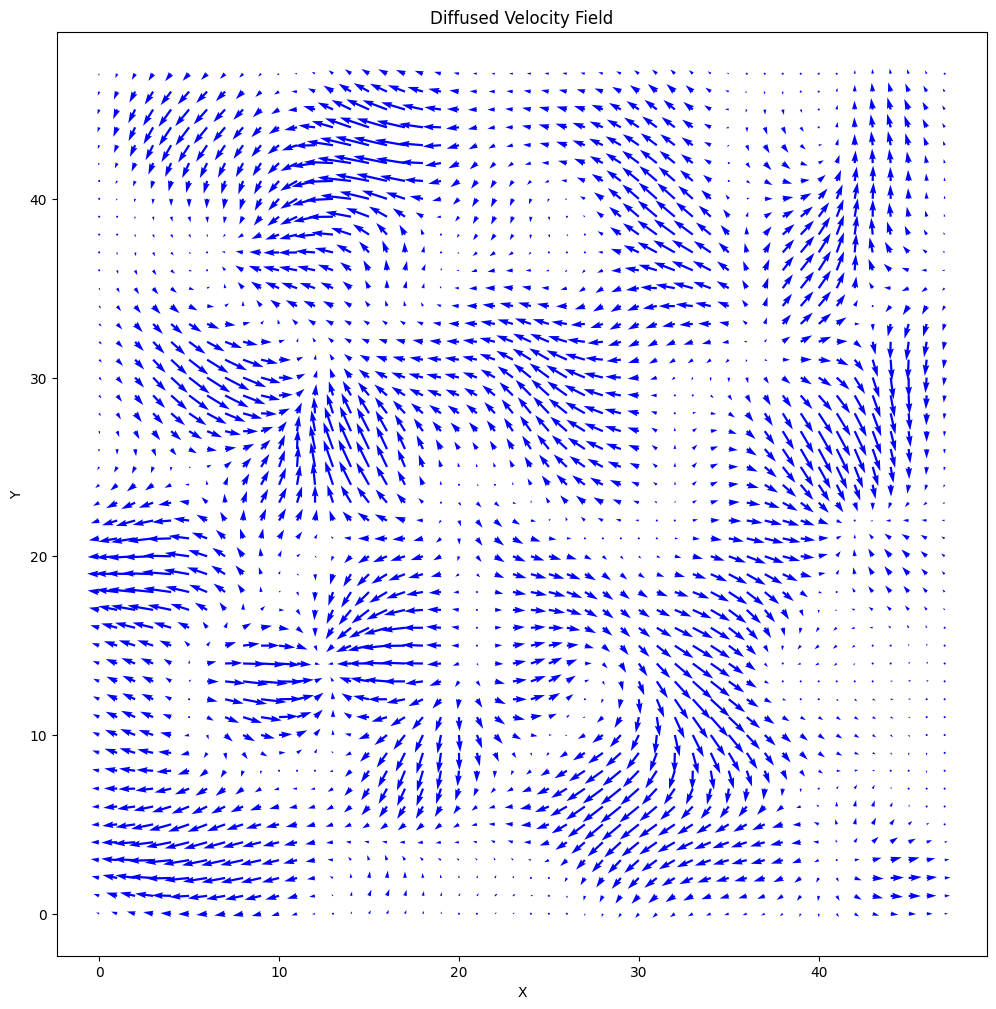

In [8]:
velocity = org_velocity.clone()

# Compute divergence
up = torch.roll(velocity, -1, dims=0)
down = torch.roll(velocity, 1, dims=0)
left = torch.roll(velocity, -1, dims=1)
right = torch.roll(velocity, 1, dims=1)

divergence = ((right[:, :, 0] - left[:, :, 0]) + (up[:, :, 1] - down[:, :, 1])) / 2

# Solve Poisson equation in Fourier space
div_fft = torch.fft.fft2(divergence)

kx = torch.fft.fftfreq(W).reshape(W, 1) * W
ky = torch.fft.fftfreq(H).reshape(1, H) * H
k2 = kx ** 2 + ky ** 2

k2[0, 0] = 1e-1  # Avoid modifying the DC component
phi_fft = div_fft / (-k2)
phi = torch.fft.ifft2(phi_fft).real

# Compute gradient of phi
grad_phi_x = (torch.roll(phi, -1, dims=1) - torch.roll(phi, 1, dims=1)) / 2
grad_phi_y = (torch.roll(phi, -1, dims=0) - torch.roll(phi, 1, dims=0)) / 2

# Subtract gradient from velocity to remove divergence
velocity[..., 0] -= grad_phi_x
velocity[..., 1] -= grad_phi_y

divergence_clean = ((torch.roll(velocity, -1, dims=0)[:, :, 1] - torch.roll(velocity, 1, dims=0)[:, :, 1]) +
                    (torch.roll(velocity, -1, dims=1)[:, :, 0] - torch.roll(velocity, 1, dims=1)[:, :, 0])) / 2

plt.imshow(divergence_clean.numpy(), cmap="coolwarm")
plt.colorbar()
plt.title("Divergence After Projection")

plot_velocity(velocity)

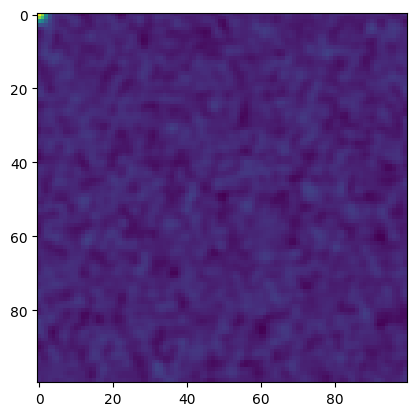

In [9]:
density, y = torch.meshgrid(
    torch.linspace(0, 10, 100),
    torch.linspace(0, 10, 100),
    indexing='ij'
)

frequencies = [(0.3, 1.2), (1.5, 0), ()]

frequencies = torch.randn(500, 2).tolist()

PI = torch.tensor(np.pi)

result = torch.zeros_like(density)

for kx, ky in frequencies:
    result += torch.cos(2 * PI * (kx * density + ky * y))

plt.imshow(result)
plt.show()

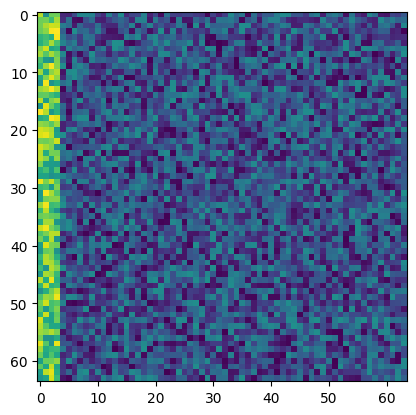

In [17]:
H, W = 64, 64

density = torch.rand(H, W)
# density *= 0.01

Y, X = torch.meshgrid(
    torch.arange(H),
    torch.arange(W),
    indexing='ij',
)

stream_spacing = 8
stream_thickness = 4

spacing = H / 2

mask = ((X % stream_spacing) <= stream_thickness)

density[:, :stream_thickness] += mask[:, :stream_thickness]

plt.imshow(density)
plt.show()

In [11]:
import solvers
import torch.nn.functional as F

frame = torch.rand(64, 64)

H, W = frame.shape[:2]

frame = F.interpolate(frame.unsqueeze(0).unsqueeze(0), size=(H // 4, W // 4), mode='bilinear', align_corners=False).squeeze()

frame.shape

torch.Size([16, 16])

8 4


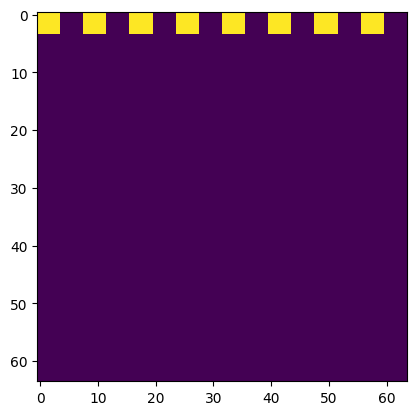

In [ ]:
Y, X = torch.meshgrid(
	torch.arange(H),
	torch.arange(W),
	indexing='ij',
)

print(stream_spacing, stream_thickness)

streamline_mask = ((Y % stream_spacing) < stream_thickness).float()
left_region_mask = (X < stream_thickness).float()

final_mask = streamline_mask * left_region_mask

plt.imshow(final_mask)
plt.show()